In [1]:
import torch
import pickle

import numpy as np
from utils.vmf_batch import vMF
from models import SeqEncoder, SeqDecoder, Seq2Seq_VAE, PoolingClassifier


## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
torch.cuda.empty_cache()

In [3]:
SEED = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def scale(X,scale=(.1,2)):
    a = scale[0]
    b = scale[1]
    s = a + (b-a)*torch.rand(1)
    return X*s

In [18]:
folder = '3_populations'
with open('./data/toy_data/%s/walk_representation_32.npy'%folder, 'rb') as f:
    walk_representation = np.load(f)
    
with open('./data/toy_data/%s/iterator/val_iterator.pkl'%folder, 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/toy_data/%s/iterator/test_iterator.pkl'%folder, 'rb') as f:
    test_iterator = pickle.load(f)

In [19]:
np.random.seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(val_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, INPUT_DIM = src_data.shape

In [20]:
# parameter
EMBED_DIM = 32                    # Size of the embedding (to prevent cheating)
HIDDEN_DIM = 32
LATENT_DIM = 32                  # latent vector dimension
KAPPA = 500
NUM_LAYERS = 2
DROPOUT = .1
NUM_CLASSES = len(np.unique(labels))



# model
enc = SeqEncoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = SeqDecoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dist = vMF(LATENT_DIM, kappa=KAPPA)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)

KLD: 45.709938049316406


In [21]:
state_dict = torch.load('./models/%s/emb32_hid32_lat32_dp0.1_k500_max_frac1.0_run1_best.pt'%folder)
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [22]:
def get_latent_representation(model, iterator):
    
    src_data, trg_data, src_len, indices, labels = list(iterator)[0]
    with torch.no_grad():
        N, n_walks, walk_length, f = src_data.shape
        src = src_data.reshape(-1,walk_length,f).transpose(0,1).to(device)
        trg = trg_data.view(-1, walk_length,f).transpose(0,1).to(device)
        src_len = src_len.view(-1).to(device)

        _ = model(src,src_len, trg, 0)
        Z = model.h

    src = src.cpu()
    src_len = src_len.cpu()
    Z = Z.cpu()

    del trg
    torch.cuda.empty_cache()
    return src, src_len, Z, labels, N

#src_train, src_len_train, Z_train, pred_label_train, indices_train, N_train = get_latent_representation(model, classifier, train_iterator)
src_val, src_len_val, Z_val, labels_val, N_val = get_latent_representation(model,  val_iterator)
src_test, src_len_test, Z_test, labels_test, N_test = get_latent_representation(model,  test_iterator)


In [23]:
Z_val = (Z_val.T/ Z_val.norm(dim=1)).T
Z_test = (Z_test.T/ Z_test.norm(dim=1)).T

### get embedding of each walk

In [24]:
from openTSNE import TSNE

import matplotlib as mpl
sns.set_context('notebook')

In [25]:
## t-SNE fit

tsne = TSNE(
    perplexity=200,
    initialization="pca",
    metric="cosine",
    n_jobs=20,
    random_state=17,
)

%time tsne_fit_val = tsne.fit(Z_val)
%time tsne_fit_test = tsne.fit(Z_test)

CPU times: user 44min 54s, sys: 17.2 s, total: 45min 11s
Wall time: 5min 5s
CPU times: user 25min 1s, sys: 17.9 s, total: 25min 19s
Wall time: 3min 36s


In [26]:
# get different color schemes

src = src_val
labels = labels_val
src_len = src_len_val
N = N_val

# plot by euclidean distance
euclidean_dist = (src[0]).norm(dim=1).to(torch.long)
ec_colors = sns.color_palette("mako_r",  n_colors=euclidean_dist.max() + 1)
c_ec = [ec_colors[k] for k in euclidean_dist]
ec_vmin = euclidean_dist.min()
ec_vmax = euclidean_dist.max()


# plot by tortuosity
path_length = (src[:-1] - src[1:]).norm(dim=2).sum(dim=0)
euclidean_dist = (src[0].norm(dim=1)*10).to(torch.long)

tortuosity = ((path_length/euclidean_dist)*10).to(torch.long)

tort_colors = sns.color_palette("mako_r",  n_colors=tortuosity.max() + 1)
c_tort = [tort_colors[k] for k in tortuosity]
tort_vmin = tortuosity.min()
tort_vmax = tortuosity.max()

# plot by population
pop_colors=sns.color_palette("pink", n_colors=NUM_CLASSES+1)
flattened_labels = labels.repeat(n_walks).view(n_walks,N).T.flatten().cpu()
c_pop = [pop_colors[k] for k in flattened_labels]


# plot by sequence length

seq_len_colors = sns.color_palette("mako",  n_colors=src.shape[0])
#sns.palplot(colors)
c_seq_len = [seq_len_colors[k] for k in src_len.to(torch.long)-1]
seq_len_vmin = src_len.min()
seq_len_vmax = src_len.max()

# plot by sign
# signs = (src[0,:,0] > 0).to(torch.long)*2
signs = (src[0,:,0]).to(torch.long)
x_vmin = signs.min()
x_vmax = signs.max()
signs = signs + signs.min().abs()
x_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)
c_xsign = [x_colors[k] for k in signs]


signs = (src[0,:,1]).to(torch.long)
y_vmin = signs.min()
y_vmax = signs.max()
signs = signs + signs.min().abs()
y_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)

c_ysign = [y_colors[k] for k in signs]

signs = (src[0,:,2]).to(torch.long)
z_vmin= signs.min()
z_vmax= signs.max()
signs = signs + signs.min().abs()
z_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)

c_zsign = [z_colors[k] for k in signs]

coloring_dict = {'Sequence': {'color': c_seq_len, 'cmap': seq_len_colors, 'vmin': seq_len_vmin, 'vmax': seq_len_vmax}, 
                'Tortuosity': {'color': c_tort, 'cmap': tort_colors,'vmin': tort_vmin, 'vmax': tort_vmax}, 
                 'Euclidean': {'color': c_ec, 'cmap': ec_colors,'vmin': ec_vmin, 'vmax': ec_vmax},
                'X-value': {'color': c_xsign, 'cmap': x_colors,'vmin': x_vmin, 'vmax': x_vmax},
                'Y-value': {'color': c_ysign, 'cmap': y_colors,'vmin': y_vmin, 'vmax': y_vmax}, 
                'Z-value': {'color': c_zsign, 'cmap': z_colors,'vmin': z_vmin, 'vmax': z_vmax}, 
                'Population': {'color': c_pop, 'cmap': pop_colors,'vmin': 0, 'vmax': 2}}

In [27]:
sns.set_context('notebook')

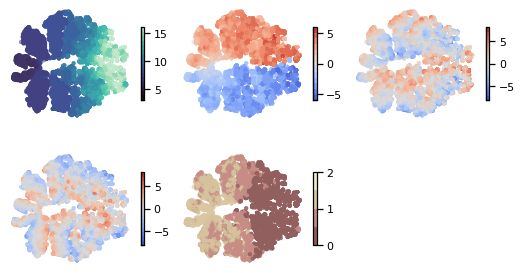

In [28]:
tsne_fit = tsne_fit_val
# plot tsne embeddings
fig =  plt.figure(figsize=(9,6))

for k, t in enumerate(['Sequence length', 
                       'X-value', 'Y-value', 'Z-value',
                       'Population']):
    
    plt.subplot(2,3,k+1)
    key = t.split(' ')[0]
    c_ = coloring_dict[key]['color']
    
    plt.scatter(tsne_fit[:,0], tsne_fit[:,1], c=c_ , s= 10, alpha=.2,rasterized=True)
    
    sns.despine()
    plt.axis('off')

    
    # create colorbar
    cmap = mpl.colors.ListedColormap(coloring_dict[key]['cmap'])
    norm = mpl.colors.Normalize(vmin=coloring_dict[key]['vmin'], vmax=coloring_dict[key]['vmax']) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    plt.colorbar(sm, shrink=.4)
    plt.gca().set_aspect('equal')


fig.subplots_adjust(wspace=.1, hspace=-.2)
# plt.savefig("./pics/ICML/v3/Fig4/latent_space_walks.svg")

# for pyramidals

In [29]:
with open('./data/M1_exc_data/walks/walk_representation.npy', 'rb') as f:
    walk_representation = np.load(f)
    
with open('./data/M1_exc_data/iterator/m_labels/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/M1_exc_data/iterator/m_labels/test_iterator.pkl', 'rb') as f:
    test_iterator = pickle.load(f)

In [30]:
np.random.seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(val_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, INPUT_DIM = src_data.shape

In [31]:
# parameter
EMBED_DIM = 32                    # Size of the embedding (to prevent cheating)
HIDDEN_DIM = 32
LATENT_DIM = 32                  # latent vector dimension
KAPPA = 500
NUM_LAYERS = 2
DROPOUT = .1
NUM_CLASSES = 3



# model
enc = SeqEncoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = SeqDecoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dist = vMF(LATENT_DIM, kappa=KAPPA)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)

KLD: 45.709938049316406


In [32]:
state_dict = torch.load('./models/M1_exc/m_label/finetuned_vae_k500_frac1.0_best_run1.pt')
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [33]:
def get_latent_representation(model, iterator):
    
    src_data, trg_data, src_len, indices, labels = list(iterator)[0]
    with torch.no_grad():
        N, n_walks, walk_length, f = src_data.shape
        src = src_data.reshape(-1,walk_length,f).transpose(0,1).to(device)
        trg = trg_data.view(-1, walk_length,f).transpose(0,1).to(device)
        src_len = src_len.view(-1).to(device)

        _ = model(src,src_len, trg, 0)
        Z = model.h
        Z = (Z.T/Z.norm(dim=1)).T

    src = src.cpu()
    src_len = src_len.cpu()
    Z = Z.cpu()

    del trg
    torch.cuda.empty_cache()
    return src, src_len, Z, labels, N

#src_train, src_len_train, Z_train, pred_label_train, indices_train, N_train = get_latent_representation(model, classifier, train_iterator)
src, src_len, Z, labels, N = get_latent_representation(model,  val_iterator)



In [34]:
from openTSNE import TSNE

import matplotlib as mpl
sns.set_context('notebook')

In [35]:
## t-SNE fit

tsne = TSNE(
    perplexity=200,
    initialization="pca",
    metric="cosine",
    n_jobs=20,
    random_state=17,
)

%time tsne_fit_val = tsne.fit(Z)


CPU times: user 9min 1s, sys: 8.88 s, total: 9min 10s
Wall time: 1min 39s


In [36]:
# get different color schemes


# plot by euclidean distance
euclidean_dist = (src[0]).norm(dim=1).to(torch.long)
ec_colors = sns.color_palette("mako_r",  n_colors=euclidean_dist.max() + 1)
c_ec = [ec_colors[k] for k in euclidean_dist]
ec_vmin = euclidean_dist.min()
ec_vmax = euclidean_dist.max()


# plot by tortuosity
path_length = (src[:-1] - src[1:]).norm(dim=2).sum(dim=0)
euclidean_dist = (src[0].norm(dim=1)*10).to(torch.long)

tortuosity = ((path_length/euclidean_dist)*10).to(torch.long)

tort_colors = sns.color_palette("mako_r",  n_colors=tortuosity.max() + 1)
c_tort = [tort_colors[k] for k in tortuosity]
tort_vmin = tortuosity.min()
tort_vmax = tortuosity.max()

# plot by population
pop_colors=['#338b5f', '#0d5d7f', '#55b7a6' ]
flattened_labels = labels.repeat(n_walks).view(n_walks,N).T.flatten().cpu()
c_pop = [pop_colors[k] for k in flattened_labels]


# plot by sequence length

seq_len_colors = sns.color_palette("mako",  n_colors=40)
#sns.palplot(colors)
c_seq_len = [seq_len_colors[k] for k in src_len.to(torch.long)-1]
seq_len_vmin = src_len.min()
seq_len_vmax = src_len.max()

# plot by sign
# signs = (src[0,:,0] > 0).to(torch.long)*2
signs = (src[0,:,0]).to(torch.long)
x_vmin = signs.min()
x_vmax = signs.max()
signs = signs + signs.min().abs()
x_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)
c_xsign = [x_colors[k] for k in signs]


signs = (src[0,:,1]).to(torch.long)
y_vmin = signs.min()
y_vmax = signs.max()
signs = signs + signs.min().abs()
y_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)

c_ysign = [y_colors[k] for k in signs]

signs = (src[0,:,2]).to(torch.long)
z_vmin= signs.min()
z_vmax= signs.max()
signs = signs + signs.min().abs()
z_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)

c_zsign = [z_colors[k] for k in signs]

coloring_dict = {'Sequence': {'color': c_seq_len, 'cmap': seq_len_colors, 'vmin': seq_len_vmin, 'vmax': seq_len_vmax}, 
                'Tortuosity': {'color': c_tort, 'cmap': tort_colors,'vmin': tort_vmin, 'vmax': tort_vmax}, 
                 'Euclidean': {'color': c_ec, 'cmap': ec_colors,'vmin': ec_vmin, 'vmax': ec_vmax},
                'X-value': {'color': c_xsign, 'cmap': x_colors,'vmin': x_vmin, 'vmax': x_vmax},
                'Y-value': {'color': c_ysign, 'cmap': y_colors,'vmin': y_vmin, 'vmax': y_vmax}, 
                'Z-value': {'color': c_zsign, 'cmap': z_colors,'vmin': z_vmin, 'vmax': z_vmax}, 
                'Population': {'color': c_pop, 'cmap': pop_colors,'vmin': 0, 'vmax': 2}}

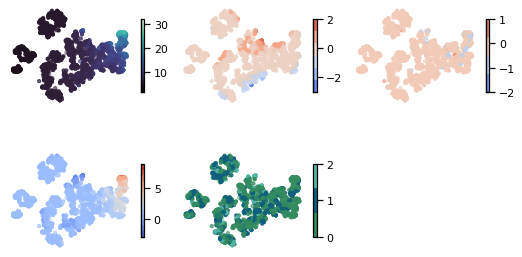

In [37]:
tsne_fit = tsne_fit_val
# plot tsne embeddings
fig =  plt.figure(figsize=(9,6))

for k, t in enumerate(['Sequence length', 
                       'X-value', 'Y-value', 'Z-value',
                       'Population']):
    
    plt.subplot(2,3,k+1)
    key = t.split(' ')[0]
    c_ = coloring_dict[key]['color']
    
    plt.scatter(tsne_fit[:,0], tsne_fit[:,1], c=c_ , s= 10, alpha=.2,rasterized=True)
    
    sns.despine()
    plt.axis('off')

    
    # create colorbar
    cmap = mpl.colors.ListedColormap(coloring_dict[key]['cmap'])
    norm = mpl.colors.Normalize(vmin=coloring_dict[key]['vmin'], vmax=coloring_dict[key]['vmax']) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    plt.colorbar(sm, shrink=.4)
    plt.gca().set_aspect('equal')


fig.subplots_adjust(wspace=.1, hspace=-.2)
# plt.savefig("./pics/ICML/resubmission/Suppl/latent_space_walks_m1_exc.svg")

# For inhibitory data

In [20]:
with open('./data/M1_inh_data/walks/axon/walk_representation_32.npy', 'rb') as f:
    walk_representation = np.load(f)
    
with open('./data/M1_inh_data/iterator/axon/val_iterator_32.pkl', 'rb') as f:
    val_iterator = pickle.load(f)


In [24]:
np.random.seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(val_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, INPUT_DIM = src_data.shape


# parameter
EMBED_DIM = 32                    # Size of the embedding (to prevent cheating)
HIDDEN_DIM = 32
LATENT_DIM = 32                  # latent vector dimension
KAPPA = 500
NUM_LAYERS = 2
DROPOUT = .1
NUM_CLASSES = 4



# model
enc = SeqEncoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = SeqDecoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dist = vMF(LATENT_DIM, kappa=KAPPA)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)

KLD: 45.709938049316406


In [25]:
state_dict = torch.load('./models/M1_inh/finetuned/axon/finetuned_vae_frac1.0_best_run1.pt')
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [26]:
src, src_len, Z, labels, N = get_latent_representation(model,  val_iterator)

In [27]:
## t-SNE fit

tsne = TSNE(
    perplexity=200,
    initialization="pca",
    metric="cosine",
    n_jobs=20,
    random_state=17,
)

%time tsne_fit_val = tsne.fit(Z)

CPU times: user 7min 24s, sys: 12.3 s, total: 7min 36s
Wall time: 1min 19s


In [29]:
# get different color schemes


# plot by euclidean distance
euclidean_dist = (src[0]).norm(dim=1).to(torch.long)
ec_colors = sns.color_palette("mako_r",  n_colors=euclidean_dist.max() + 1)
c_ec = [ec_colors[k] for k in euclidean_dist]
ec_vmin = euclidean_dist.min()
ec_vmax = euclidean_dist.max()


# plot by tortuosity
path_length = (src[:-1] - src[1:]).norm(dim=2).sum(dim=0)
euclidean_dist = (src[0].norm(dim=1)*10).to(torch.long)

tortuosity = ((path_length/euclidean_dist)*10).to(torch.long)

tort_colors = sns.color_palette("mako_r",  n_colors=tortuosity.max() + 1)
c_tort = [tort_colors[k] for k in tortuosity]
tort_vmin = tortuosity.min()
tort_vmax = tortuosity.max()

# plot by population
pop_colors=[ '#fd9e2b', '#e0285d',  '#aa369a', '#fda389']
flattened_labels = labels.repeat(n_walks).view(n_walks,N).T.flatten().cpu()
c_pop = [pop_colors[k] for k in flattened_labels]


# plot by sequence length

seq_len_colors = sns.color_palette("mako",  n_colors=40)
#sns.palplot(colors)
c_seq_len = [seq_len_colors[k] for k in src_len.to(torch.long)-1]
seq_len_vmin = src_len.min()
seq_len_vmax = src_len.max()

# plot by sign
# signs = (src[0,:,0] > 0).to(torch.long)*2
signs = (src[0,:,0]).to(torch.long)
x_vmin = signs.min()
x_vmax = signs.max()
signs = signs + signs.min().abs()
x_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)
c_xsign = [x_colors[k] for k in signs]


signs = (src[0,:,1]).to(torch.long)
y_vmin = signs.min()
y_vmax = signs.max()
signs = signs + signs.min().abs()
y_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)

c_ysign = [y_colors[k] for k in signs]

signs = (src[0,:,2]).to(torch.long)
z_vmin= signs.min()
z_vmax= signs.max()
signs = signs + signs.min().abs()
z_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)

c_zsign = [z_colors[k] for k in signs]

coloring_dict = {'Sequence': {'color': c_seq_len, 'cmap': seq_len_colors, 'vmin': seq_len_vmin, 'vmax': seq_len_vmax}, 
                'Tortuosity': {'color': c_tort, 'cmap': tort_colors,'vmin': tort_vmin, 'vmax': tort_vmax}, 
                 'Euclidean': {'color': c_ec, 'cmap': ec_colors,'vmin': ec_vmin, 'vmax': ec_vmax},
                'X-value': {'color': c_xsign, 'cmap': x_colors,'vmin': x_vmin, 'vmax': x_vmax},
                'Y-value': {'color': c_ysign, 'cmap': y_colors,'vmin': y_vmin, 'vmax': y_vmax}, 
                'Z-value': {'color': c_zsign, 'cmap': z_colors,'vmin': z_vmin, 'vmax': z_vmax}, 
                'Population': {'color': c_pop, 'cmap': pop_colors,'vmin': 0, 'vmax': 2}}

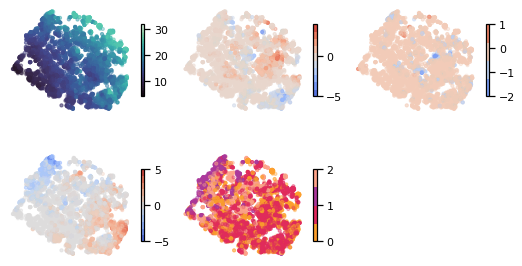

In [30]:
tsne_fit = tsne_fit_val
# plot tsne embeddings
fig =  plt.figure(figsize=(9,6))

for k, t in enumerate(['Sequence length', 
                       'X-value', 'Y-value', 'Z-value',
                       'Population']):
    
    plt.subplot(2,3,k+1)
    key = t.split(' ')[0]
    c_ = coloring_dict[key]['color']
    
    plt.scatter(tsne_fit[:,0], tsne_fit[:,1], c=c_ , s= 10, alpha=.2,rasterized=True)
    
    sns.despine()
    plt.axis('off')

    
    # create colorbar
    cmap = mpl.colors.ListedColormap(coloring_dict[key]['cmap'])
    norm = mpl.colors.Normalize(vmin=coloring_dict[key]['vmin'], vmax=coloring_dict[key]['vmax']) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    plt.colorbar(sm, shrink=.4)
    plt.gca().set_aspect('equal')


fig.subplots_adjust(wspace=.1, hspace=-.2)
# plt.savefig("./pics/ICML/resubmission/Suppl/latent_space_walks_m1_inh.svg")

### For RGC data

In [41]:
with open('./data/Farrow_data/iterator/soma_centered/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)


In [43]:
np.random.seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(val_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, INPUT_DIM = src_data.shape


# parameter
EMBED_DIM = 32                    # Size of the embedding (to prevent cheating)
HIDDEN_DIM = 32
LATENT_DIM = 32                  # latent vector dimension
KAPPA = 500
NUM_LAYERS = 2
DROPOUT = .1
NUM_CLASSES = 14



# model
enc = SeqEncoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = SeqDecoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dist = vMF(LATENT_DIM, kappa=KAPPA)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)


state_dict = torch.load('./models/Farrow/finetuned/soma_centered/finetuned_vae_frac1.0_best_run1.pt')
model.load_state_dict(state_dict['model_state_dict'])

KLD: 45.709938049316406


<All keys matched successfully>

In [44]:
src, src_len, Z, labels, N = get_latent_representation(model,  val_iterator)

## t-SNE fit

tsne = TSNE(
    perplexity=200,
    initialization="pca",
    metric="cosine",
    n_jobs=20,
    random_state=17,
)

%time tsne_fit_val = tsne.fit(Z)

CPU times: user 15min 12s, sys: 14.5 s, total: 15min 26s
Wall time: 2min 19s


In [46]:
labels[labels == -100] = 14

In [47]:
# get different color schemes


# plot by euclidean distance
euclidean_dist = (src[0]).norm(dim=1).to(torch.long)
ec_colors = sns.color_palette("mako_r",  n_colors=euclidean_dist.max() + 1)
c_ec = [ec_colors[k] for k in euclidean_dist]
ec_vmin = euclidean_dist.min()
ec_vmax = euclidean_dist.max()


# plot by tortuosity
path_length = (src[:-1] - src[1:]).norm(dim=2).sum(dim=0)
euclidean_dist = (src[0].norm(dim=1)*10).to(torch.long)

tortuosity = ((path_length/euclidean_dist)*10).to(torch.long)

tort_colors = sns.color_palette("mako_r",  n_colors=tortuosity.max() + 1)
c_tort = [tort_colors[k] for k in tortuosity]
tort_vmin = tortuosity.min()
tort_vmax = tortuosity.max()

# plot by population
pop_colors= sns.color_palette('icefire', n_colors=15)
flattened_labels = labels.repeat(n_walks).view(n_walks,N).T.flatten().cpu()
c_pop = [pop_colors[k] for k in flattened_labels]


# plot by sequence length

seq_len_colors = sns.color_palette("mako",  n_colors=40)
#sns.palplot(colors)
c_seq_len = [seq_len_colors[k] for k in src_len.to(torch.long)-1]
seq_len_vmin = src_len.min()
seq_len_vmax = src_len.max()

# plot by sign
# signs = (src[0,:,0] > 0).to(torch.long)*2
signs = (src[0,:,0]).to(torch.long)
x_vmin = signs.min()
x_vmax = signs.max()
signs = signs + signs.min().abs()
x_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)
c_xsign = [x_colors[k] for k in signs]


signs = (src[0,:,1]).to(torch.long)
y_vmin = signs.min()
y_vmax = signs.max()
signs = signs + signs.min().abs()
y_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)

c_ysign = [y_colors[k] for k in signs]

signs = (src[0,:,2]).to(torch.long)
z_vmin= signs.min()
z_vmax= signs.max()
signs = signs + signs.min().abs()
z_colors = sns.color_palette('coolwarm', n_colors=signs.max()+1)

c_zsign = [z_colors[k] for k in signs]

coloring_dict = {'Sequence': {'color': c_seq_len, 'cmap': seq_len_colors, 'vmin': seq_len_vmin, 'vmax': seq_len_vmax}, 
                'Tortuosity': {'color': c_tort, 'cmap': tort_colors,'vmin': tort_vmin, 'vmax': tort_vmax}, 
                 'Euclidean': {'color': c_ec, 'cmap': ec_colors,'vmin': ec_vmin, 'vmax': ec_vmax},
                'X-value': {'color': c_xsign, 'cmap': x_colors,'vmin': x_vmin, 'vmax': x_vmax},
                'Y-value': {'color': c_ysign, 'cmap': y_colors,'vmin': y_vmin, 'vmax': y_vmax}, 
                'Z-value': {'color': c_zsign, 'cmap': z_colors,'vmin': z_vmin, 'vmax': z_vmax}, 
                'Population': {'color': c_pop, 'cmap': pop_colors,'vmin': 0, 'vmax': 2}}

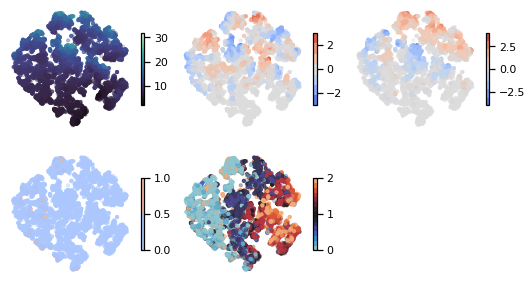

In [48]:
tsne_fit = tsne_fit_val
# plot tsne embeddings
fig =  plt.figure(figsize=(9,6))

for k, t in enumerate(['Sequence length', 
                       'X-value', 'Y-value', 'Z-value',
                       'Population']):
    
    plt.subplot(2,3,k+1)
    key = t.split(' ')[0]
    c_ = coloring_dict[key]['color']
    
    plt.scatter(tsne_fit[:,0], tsne_fit[:,1], c=c_ , s= 10, alpha=.2,rasterized=True)
    
    sns.despine()
    plt.axis('off')

    
    # create colorbar
    cmap = mpl.colors.ListedColormap(coloring_dict[key]['cmap'])
    norm = mpl.colors.Normalize(vmin=coloring_dict[key]['vmin'], vmax=coloring_dict[key]['vmax']) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    plt.colorbar(sm, shrink=.4)
    plt.gca().set_aspect('equal')


fig.subplots_adjust(wspace=.1, hspace=-.2)
plt.savefig("./pics/ICML/resubmission/Suppl/latent_space_walks_rgc.svg")